In [36]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from dataset.sentinel import *
from models.conv_ae_1D import *
import torch
import random
from torchvision.transforms import transforms as T, Lambda
from config import *
import sys
sys.path.append('../esa')
from esa.utils import *
from esa.conv_utils import *

import numpy as np

architecture = 'conv_ae1D'

In [37]:
model_list = os.listdir(model_results+ '{}/'.format(architecture))
for ix, mn in enumerate(model_list):  
    print('model num {}: {}'.format(ix,model_list[ix]))

model num 0: conv_ae1D_sl_16_filter_n_110_kernel_size_7_22_03_2023_11:13:19.pth
model num 1: conv_ae1D_sl_16_filter_n_110_kernel_size_7_22_03_2023_11:02:06.pth


In [38]:
selected_model = 0
print(model_list[selected_model])
model_name = model_list[selected_model].split('.')[0]

conv_ae1D_sl_16_filter_n_110_kernel_size_7_22_03_2023_11:13:19.pth


In [46]:
try:
    sm = str(torch.cuda.get_device_capability())
    sm = ''.join((sm.strip('()').split(',')[0], sm.strip('()').split(',')[1])).replace(' ', '')
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda:0" if use_cuda and sm in torch.cuda.get_arch_list() else "cpu")
except:
    device='cpu'

In [47]:
checkpoint  = torch.load(model_results+ '{}/'.format(architecture) + '/' + model_list[selected_model]
                         , map_location=device)
params_conf = checkpoint['param_conf']

In [48]:
#cols = params_conf['columns']
cols = params_conf['columns']
params_conf['n_features'] = len(cols)
sequence_length = params_conf['sequence_length']
batch_size = params_conf['batch_size']
predict = params_conf['predict']
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
out_window = params_conf['out_window']

n_features = params_conf['n_features']
scaled = params_conf['scaled']
sampling_rate = params_conf['sampling_rate']

columns_subset = params_conf['columns_subset']
dataset_subset = params_conf['dataset_subset']

data_path = params_conf['data_path']
dataset = params_conf['name']
train_val_split = params_conf['train_val_split']

target = params_conf['target']
batch_size = params_conf['batch_size']
sequence_length = params_conf['sequence_length']
out_window = params_conf['out_window']
predict = params_conf['predict']
activation = params_conf['activation']
kernel_size = params_conf['kernel_size']
filter_num = params_conf['filter_num']
latent_dim = params_conf['latent_dim']
n_layers = params_conf['n_layers']

In [49]:
if 'flattened' in params_conf.keys():
    flattened = flattened=params_conf['flattened']
else:
    flattened=False
if 'increasing' in params_conf.keys():
    increasing = flattened=params_conf['increasing']
else:
    increasing=False
    
model = CONV_AE1D(in_channel=params_conf['n_features'],  length=params_conf['sequence_length']
                  , kernel_size=params_conf['kernel_size'], filter_num=params_conf['filter_num'],
                  latent_dim = params_conf['latent_dim'],
                 n_layers=params_conf['n_layers'], activation = params_conf['activation']
                  , stride=params_conf['stride'], pool=params_conf['pool'],
                  flattened=flattened, increasing=increasing, bn = params_conf['bn']).to(device).float()

Initializing conv2d weights with Kaiming He normal
Initializing conv2d weights with Kaiming He normal
CONV_AE1D(
  (act): ELU(alpha=1.0)
  (encoder): Encoder(
    (nn_enc): Sequential(
      (enc_lay_0): Sequential(
        (0): Conv1d(16, 110, kernel_size=(7,), stride=(1,), padding=(3,))
        (1): BatchNorm1d(110, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (3): ELU(alpha=1.0)
      )
      (enc_lay_1): Sequential(
        (0): Conv1d(110, 55, kernel_size=(7,), stride=(1,), padding=(3,))
        (1): BatchNorm1d(55, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (3): ELU(alpha=1.0)
      )
    )
    (act): ELU(alpha=1.0)
  )
  (decoder): Decoder(
    (nn_dec): Sequential(
      (dec_lay_0): Sequential(
        (0): ConvTranspose1d(55, 110, kernel_size=(2,),

In [50]:
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
par_nums = count_parameters(model)
print('number of params', par_nums)

number of params 71435


In [51]:
transform = T.Compose([
    T.ToTensor(),
    Lambda(lambda x: x.permute((0, 2, 1))),
    Lambda(lambda x: x.squeeze())
])

dataset_name = os.path.join(data_path, "all_2016-2018_clean_std_4s.pkl")
df_train, df_test, train_iter, test_iter = \
read_dataset_conv(dataset_name, params_conf['scaled'],params_conf['columns_subset']
                  , params_conf['dataset_subset'], params_conf['columns'], 
                 params_conf['train_val_split'], params_conf['sequence_length']
                  ,params_conf['sequence_length'],  predict=False,
                 batch_size=4, transform=transform )

In [52]:
compute_mse_val_loss = False

In [53]:
mse_val_loss_list = []
criterion = nn.MSELoss()
if compute_mse_val_loss:
    for i, (x,y) in enumerate(test_iter):
        yo = model(x)
        mse_val_loss_list.append(criterion(yo, x).item())
    mse_val_loss = np.mean(mse_val_loss_list)
    print(mse_val_loss)

In [54]:
num_batch = 5

x, shift = unrolling_batches_conv(num_batch=num_batch, test_iter=test_iter, arch='conv_ae1D',
                         sequence_length=sequence_length, cols=cols, shift = None)
    
print('time horizon', num_batch*params_conf['sequence_length'])

time horizon 80


In [55]:
yo = model(x.to(device))

In [56]:
seq_len = sequence_length
par_nums = count_parameters(model)

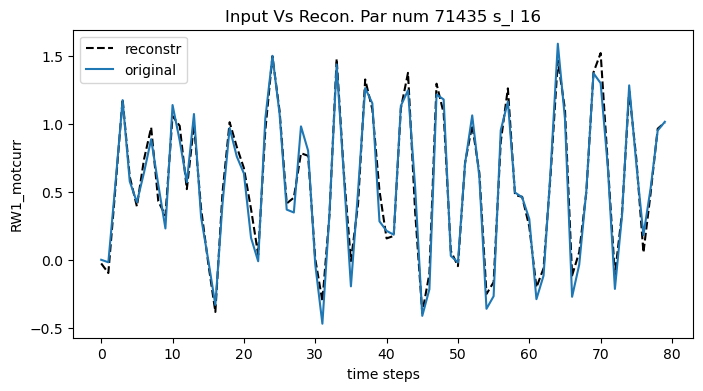

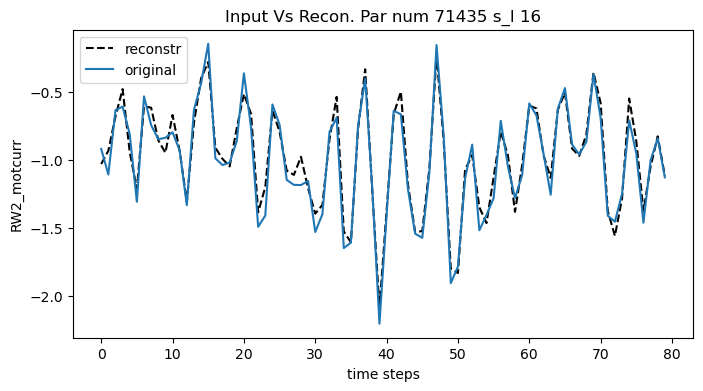

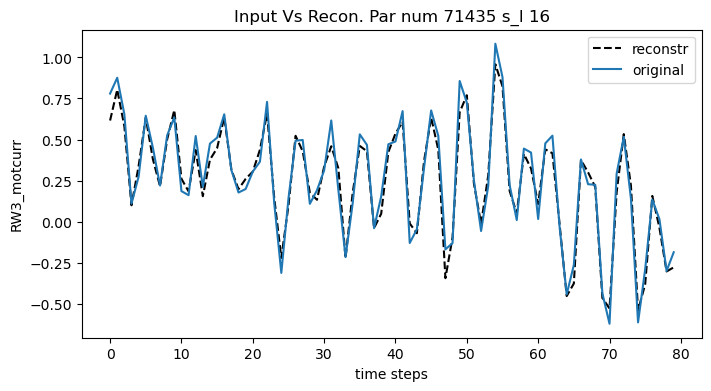

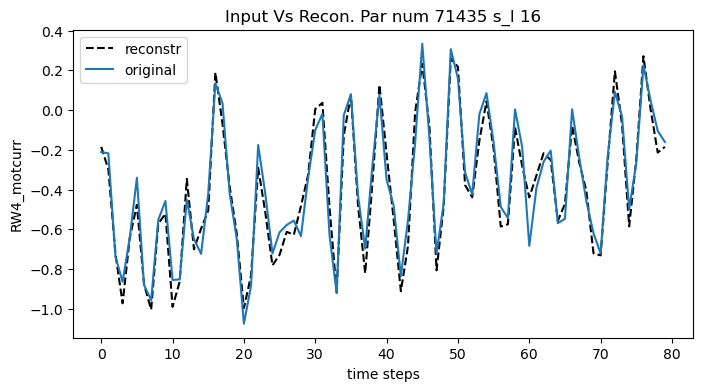

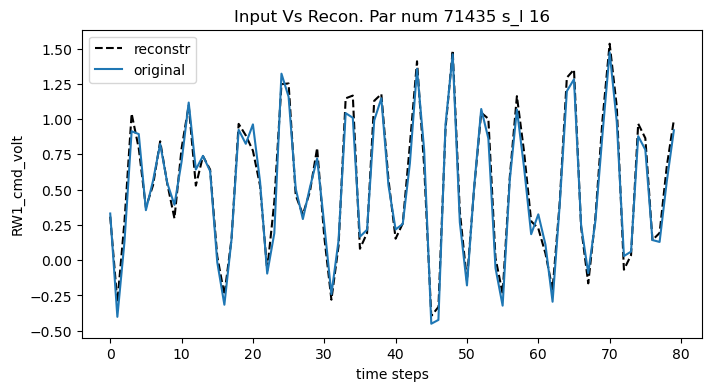

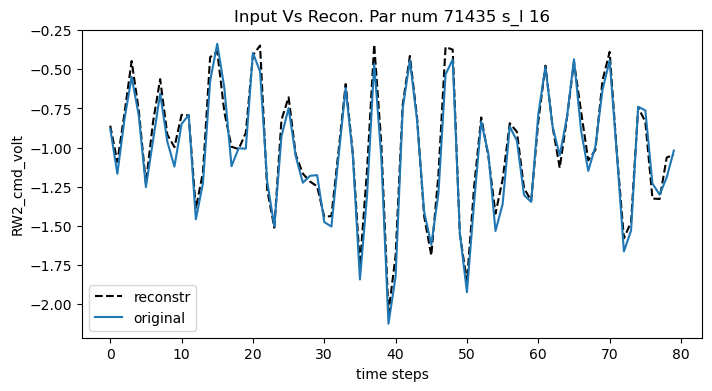

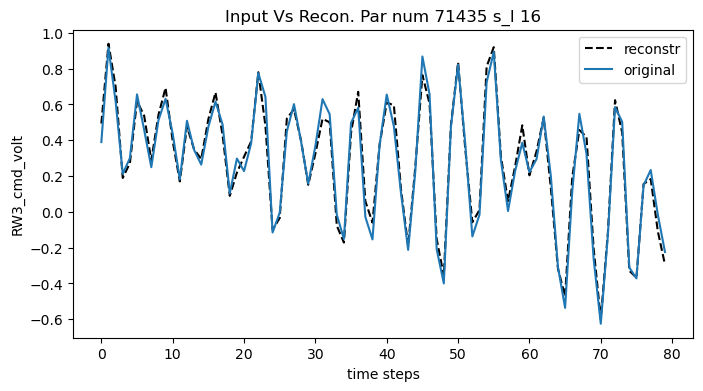

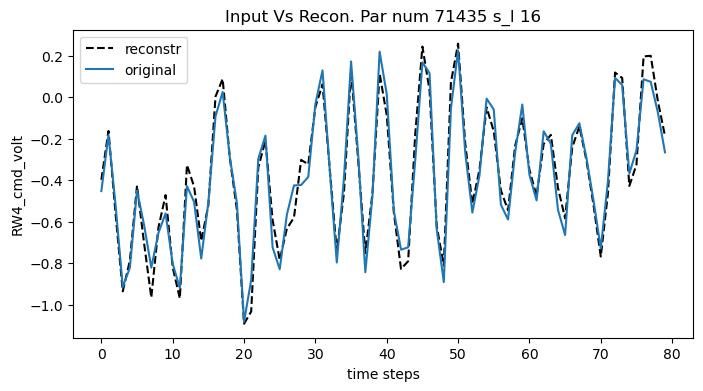

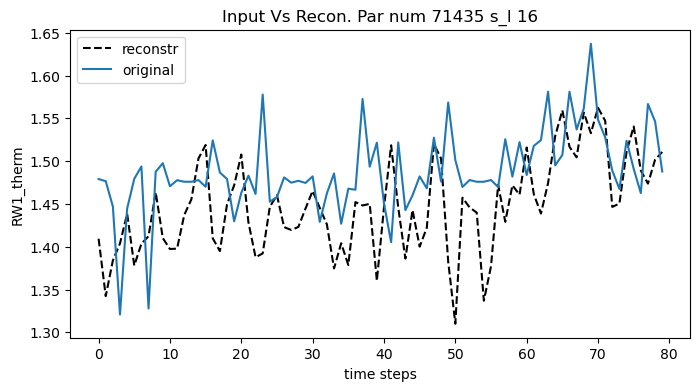

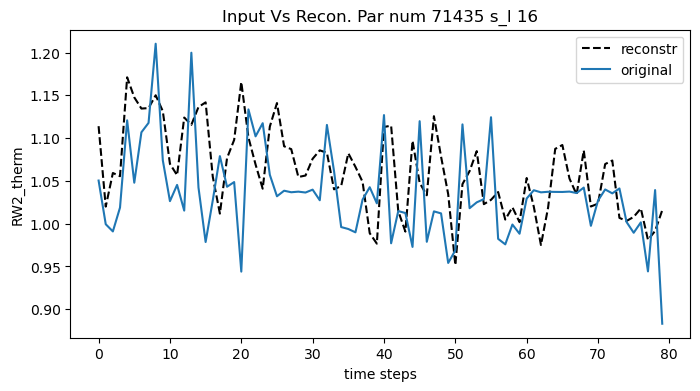

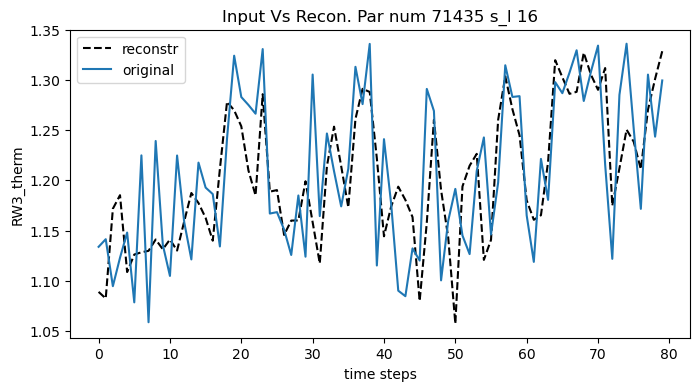

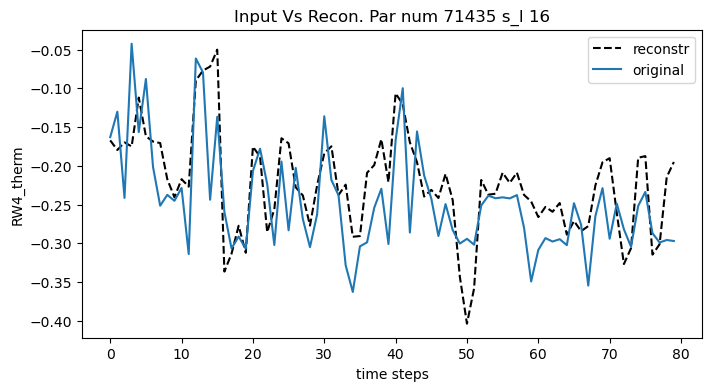

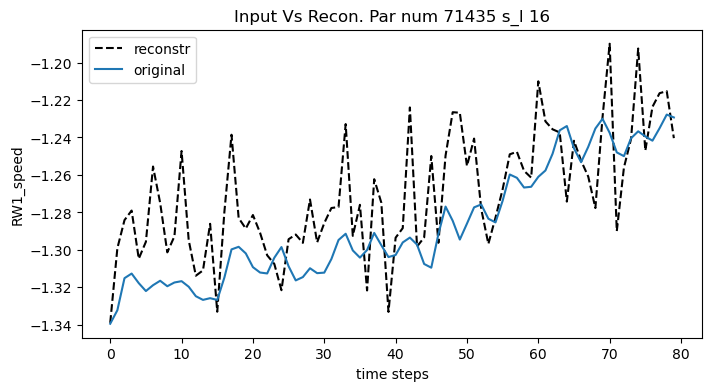

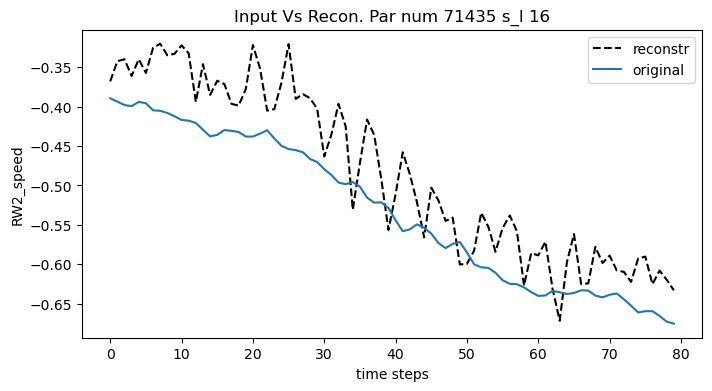

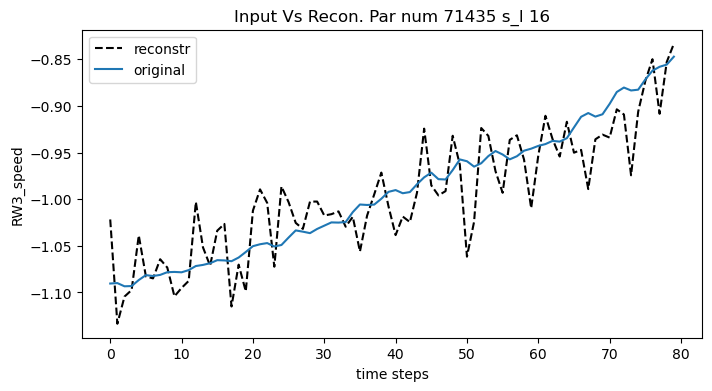

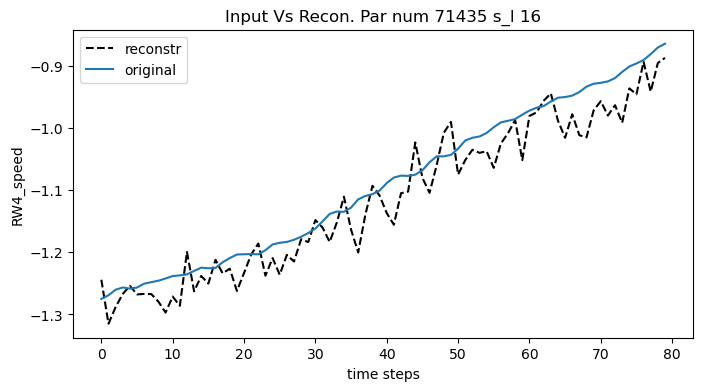

In [57]:
x_plot = x.squeeze().to(device)
show_results(x_plot , yo, cols, model_name, params_conf
     , par_nums, shift, num_batch,arch=architecture,save=False)